In [2]:
%config IPCompleter.greedy=True

import matplotlib
matplotlib.rcParams['font.family'] = 'Lato'
matplotlib.rcParams['font.size'] = 42
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['axes.labelpad'] = 20

matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.direction'] = 'out'


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

font_paths = ['Lato-Black', 'Lato-BlackItalic', 'Lato-Bold', 'Lato-BoldItalic', 'Lato-Italic', 'Lato-Light', 'Lato-LightItalic', 'Lato-Regular', 'Lato-Thin', 'Lato-ThinItalic']

prop = font_manager.FontProperties(fname='../font_Lato/' + font_paths[7] + '.ttf')
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = prop.get_name()

import numpy as np
import pandas as pd

import plots
import plotting_helpers

from scipy.optimize import curve_fit

### Load and calculate data
#### Load coordinate data, calculate locomotion metrics

In [3]:
maze_behaviour = pd.read_csv("maze_behaviour.csv")

speed_period = 5
port_position_radius = [50/60, 58/60]
port_angle_deviation_threshold = 6

visit_speed_window_from = 5
visit_speed_window_to = 25

def speed(x, axes, period=speed_period):    
    return pd.Series(np.linalg.norm(x[axes].diff(periods=speed_period).shift(-speed_period//2), axis=1))
    
def nose_angle(coords):
    return np.angle((coords['Y_nose_abs'])+(coords['X_nose_abs'])*1j, deg=True)

def speed_angle(coords):
    return np.angle(coords['Y_speed']+coords['X_speed']*1j, deg=True)

# The port investigation area is defined as within 6 degrees of angular deviation from the port centre and 50-58 cm from the maze centre (opening side of ports)
def in_port(x):
    return ((x['Angle deviation']<port_angle_deviation_threshold) & (x['Distance from centre']>port_position_radius[0]) & (x['Distance from centre']<=port_position_radius[1])).astype(int)

# The centre area is defined as within 20 cm from the maze centre (opening side of ports)
def in_centre(x):
    return (x['Distance from centre']<20/60).astype(int)

# X_nose is relative to mouse centre, X_nose_abs is relative to maze centre
maze_behaviour['X_nose_abs'] = maze_behaviour['X_centre'] + maze_behaviour['X_nose']
maze_behaviour['Y_nose_abs'] = maze_behaviour['Y_centre'] + maze_behaviour['Y_nose']

maze_behaviour['Position angle'] = nose_angle(maze_behaviour)
maze_behaviour['Angle deviation'] = 22.5-np.abs(maze_behaviour['Position angle']%45-22.5)
maze_behaviour['Closest port'] = np.round(maze_behaviour['Position angle'] / 45) * 45

maze_behaviour.loc[maze_behaviour['Closest port']==-180,'Closest port'] = 180

maze_behaviour['Distance from closest'] = np.sqrt(np.power(np.sin(np.radians(maze_behaviour['Closest port']))*port_position_radius[0] - maze_behaviour["X_nose_abs"],2) + np.power(np.cos(np.radians(maze_behaviour['Closest port']))*port_position_radius[0] - maze_behaviour["Y_nose_abs"],2))
maze_behaviour['Distance from exit'] = np.sqrt(np.power(np.sin(np.radians(180))*port_position_radius[0] - maze_behaviour["X_nose_abs"],2) + np.power(np.cos(np.radians(180))*port_position_radius[0] - maze_behaviour["Y_nose_abs"],2))
maze_behaviour['Distance from centre'] = np.hypot(maze_behaviour['X_nose_abs'],maze_behaviour['Y_nose_abs'])


maze_behaviour['X_speed'] = maze_behaviour['X_centre'].diff(periods=speed_period).shift(-speed_period//2)
maze_behaviour['Y_speed'] = maze_behaviour['Y_centre'].diff(periods=speed_period).shift(-speed_period//2)

maze_behaviour['Heading direction'] = speed_angle(maze_behaviour)
maze_behaviour['Speed to port'] = -maze_behaviour.groupby("Trial id")['Distance from closest'].diff(periods=speed_period).shift(-speed_period//2)
maze_behaviour['Trial sample'] = maze_behaviour.groupby("Trial id").cumcount()

maze_behaviour['Speed'] = maze_behaviour.groupby('Trial id').apply(speed, axes=['X_centre', 'Y_centre']).reset_index()[0]
maze_behaviour['Nose speed'] = maze_behaviour.groupby('Trial id').apply(speed, axes=['X_nose_abs', 'Y_nose_abs']).reset_index()[0]
maze_behaviour['Acceleration'] = maze_behaviour.groupby("Trial id")['Speed'].diff(periods=speed_period).shift(-speed_period//2)
maze_behaviour['Nose acceleration'] = maze_behaviour.groupby("Trial id")['Speed'].diff(periods=speed_period).shift(-speed_period//2)

maze_behaviour['In port'] = maze_behaviour.groupby('Trial id').apply(in_port).reset_index()[0]
maze_behaviour['In centre'] = maze_behaviour.groupby('Trial id').apply(in_centre).reset_index()['Distance from centre']

maze_behaviour['Crossed port border'] = maze_behaviour.groupby('Trial id').apply(lambda x: x['In port'].astype(int).diff().fillna(x['In port'])).reset_index()['In port']

maze_behaviour = maze_behaviour[(maze_behaviour["Genotype"]=="VGAT")]

#### Calculate parameters and metrics of port visits

In [4]:
def port_visits(x):        
    starts = x[x['Crossed port border']==1].index
    ends = x[x['Crossed port border']==-1].index    
    x['Start'] = x.index    
    for st in starts:
        if st == x.index[-1]:
            starts = starts.delete(len(starts)-1)
    # Closing unfinished visits at end of trial
        elif len(ends[ends>st])==0:                        
            ends = ends.append(pd.Index([x.index[-1]]))    
    x.loc[starts, 'End'] = ends 
    x['Port'] = x.loc[starts, 'Closest port'] 
    x['Visit speed'] = np.nan
    x['Exit visit'] = False
    # Merging re-entries to the same port
    for i, _ in enumerate(starts):
        if i>0:
            if x.loc[starts[i], 'Closest port'] == x.loc[starts[i-1], 'Closest port']:
                # Exclude trips to the centre zone
                stayed_at_perimeter = x.loc[ends[i-1]:starts[i], 'Distance from centre'].min() > 0.65
                stayed_at_port_angle = x.loc[ends[i-1]:starts[i], 'Angle deviation'].max() < 18               
                if stayed_at_perimeter & stayed_at_port_angle:                       
                    x.loc[starts[i-1], 'End'] = x.loc[starts[i], 'End']
                    x.loc[starts[i], 'Start'] = np.nan
                    x.loc[starts[i], 'End'] = np.nan
    for i, _ in enumerate(starts):        
        x.loc[starts[i], 'Visit speed'] = x.loc[starts[i]-visit_speed_window_from:starts[i]+visit_speed_window_to, 'Speed'].mean()
        if i==len(starts)-1:
            if x.loc[starts[i], 'Port'] == 0:
                x.loc[starts[i], 'Exit visit']=True
    return x.loc[starts, :].dropna()

port_visits = maze_behaviour.groupby('Trial id').apply(port_visits).reset_index(drop=True).loc[:,['Genotype','Animal','Day','Trial','Trial id','Start', 'End', 'Port', 'Visit speed', 'Exit visit']]
port_visits = port_visits[~port_visits['Exit visit']]

### Plot port zones

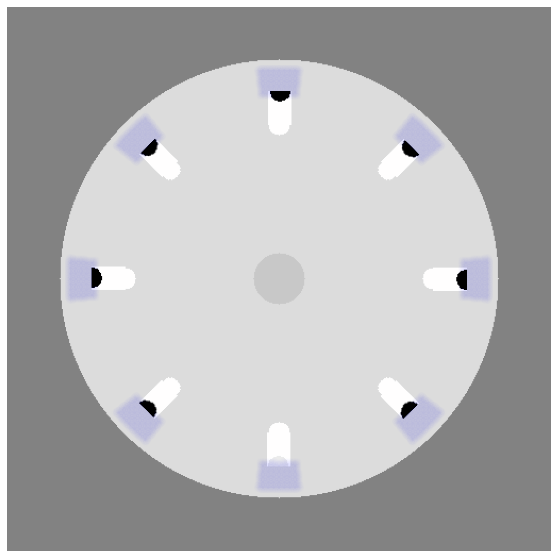

In [5]:
mesh = np.meshgrid(np.linspace(-1.4,1.4,500),np.linspace(-1.4,1.4,500))
mesh_df = pd.DataFrame({'Trial id':1, 'X_centre': mesh[0].flatten(), 'Y_centre': mesh[1].flatten(), 'Exit_angle': 180, 'X_nose': 0, 'Y_nose': 0, 'X_tail': 0, 'Y_tail': 0, 'Area': 0})
mesh_df['X_nose_abs'] = mesh_df['X_centre']
mesh_df['Y_nose_abs'] = mesh_df['Y_centre']

mesh_df['Position angle'] = nose_angle(mesh_df)
mesh_df['Angle deviation'] = 22.5-np.abs(mesh_df['Position angle']%45-22.5)
mesh_df['Closest port'] = np.round(mesh_df['Position angle'] / 45) * 45

mesh_df.loc[mesh_df['Closest port']==-180,'Closest port'] = 180

mesh_df['X_speed'] = mesh_df['X_centre'].diff(periods=speed_period).shift(-speed_period//2)
mesh_df['Y_speed'] = mesh_df['Y_centre'].diff(periods=speed_period).shift(-speed_period//2)

mesh_df['Distance from closest']  = np.sqrt(np.power(np.sin(np.radians(mesh_df['Closest port']))*port_position_radius[0] - mesh_df["X_nose_abs"],2) + np.power(np.cos(np.radians(mesh_df['Closest port']))*port_position_radius[0] - mesh_df["Y_nose_abs"],2))
mesh_df['Distance from exit'] = np.sqrt(np.power(np.sin(np.radians(180))*port_position_radius[0] - mesh_df["X_nose_abs"],2) + np.power(np.cos(np.radians(180))*port_position_radius[0] - mesh_df["Y_nose_abs"],2))
mesh_df['Distance from centre'] = np.hypot(mesh_df['X_nose_abs'],mesh_df['Y_nose_abs'])

mesh_df['In port'] = mesh_df.groupby('Trial id').apply(in_port).reset_index().T[0]
mesh_df['In centre'] = mesh_df.groupby('Trial id').apply(in_centre).reset_index().T[0]

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(plotting_helpers.render_arena(0, 512, rotation_angle=180, room_shading=False), cmap='gray')
plt.scatter(mesh_df['X_nose_abs']*256/1.24+256, mesh_df['Y_nose_abs']*256/1.24+256, c=-mesh_df['In port'], cmap='bwr', alpha=0.005)
plt.xlim([0,512])
plt.ylim([0,512])
plt.clim([-1,1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.show()

### Plot port visits

findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


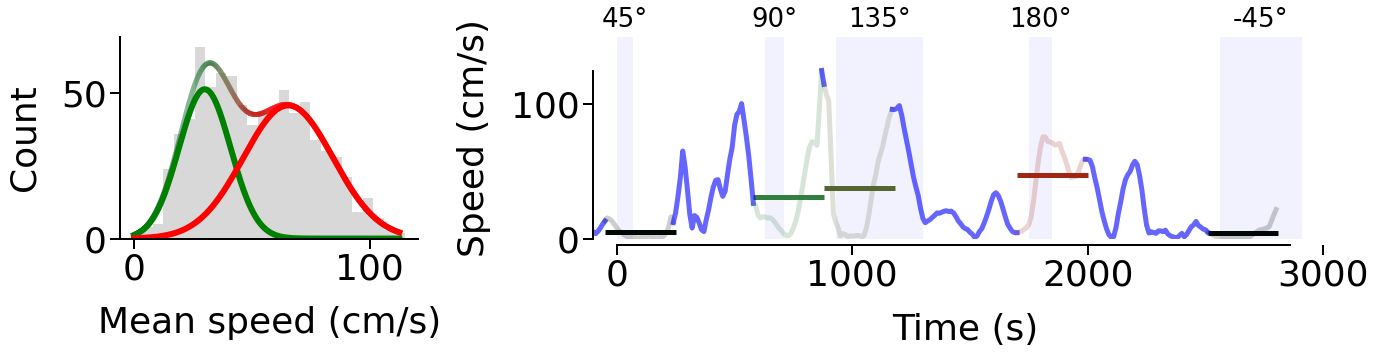

In [6]:
matplotlib.rcParams['font.size'] = 36

fig, ax = plt.subplots(1,2,figsize=(20,6), gridspec_kw={'width_ratios': [1, 2.5]})

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

y,x,_=ax[0].hist(port_visits['Visit speed']*60*10, 25, color='grey', alpha=0.3)

x=(x[1:]+x[:-1])/2
expected=(25,10,50,75,10,50)
params,cov=curve_fit(bimodal,x,y,expected)

x = np.linspace(0,max(x),1000)

def bimodal_color(xi, alpha=0.1):
    return (gauss(xi,*params[3:])/max(gauss(x,*params[3:])),gauss(xi,*params[:3])/max(gauss(x,*params[:3]))/2,gauss(xi,*params[:3])/max(gauss(x,*params[:3]))/4, alpha)

for i, xi in enumerate(x):
    if i>0:
        ax[0].plot([x[i-1],x[i]],bimodal([x[i-1],x[i]],*params),lw=5,label='model', color=bimodal_color(x[i]))
ax[0].plot(x,gauss(x,*params[:3]),lw=6,label='model', color='g')
ax[0].plot(x,gauss(x,*params[3:]),lw=6,label='model', color='r')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# ax[0].spines['left'].set_bounds(0, max_speed)
# ax[0].spines['bottom'].set_bounds(0, ax[1].get_xlim()[1]-200)
ax[0].set_xlabel("Mean speed (cm/s)", linespacing = 1.25)
ax[0].set_ylabel("Count", linespacing = 1.25)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_position(('data', -5))

frequent_visits = np.where(port_visits['Start'].diff(5).shift(-5)<200)[0]
port_variance = []
speed_variance = []
for f in frequent_visits:
    port_variance.append(port_visits.loc[f:f+5,'Port'].std())
    speed_variance.append(port_visits.loc[f:f+5,'Visit speed'].std())

port_variance = np.array(port_variance)
speed_variance = np.array(speed_variance)
port_variance>100
# plt.hist(speed_variance)

quality = np.argsort(speed_variance*port_variance)


example_visit_index = quality[7]
example_visits = port_visits.loc[example_visit_index:example_visit_index+4,:]

example_starts = example_visits['Start'].to_numpy() 
example_first_index = int(example_starts[0])
example_starts = example_starts - example_first_index
example_ends = example_visits['End'].to_numpy()
example_ends = example_ends - example_first_index

example_trace = maze_behaviour.loc[-visit_speed_window_from*2:example_starts[-1]+visit_speed_window_to+1+example_first_index, :]

mouse_speed = maze_behaviour['Speed']*60*10
example_mids = (example_starts + example_ends) / 2
example_ports = example_visits['Port'].to_numpy()

from_index_blue = -visit_speed_window_from*2
for i, _ in enumerate(example_starts):
    from_index_red = int(example_starts[i]) - visit_speed_window_from
    to_index_red = int(example_starts[i]) + visit_speed_window_to
    x_blue = np.arange(from_index_blue,from_index_red+1)*10
    speed_blue = mouse_speed[from_index_blue+example_first_index:from_index_red+1+example_first_index]
    ax[1].plot(x_blue, speed_blue, color='b', linewidth=5, alpha=0.6)
    x_red = np.arange(from_index_red,to_index_red)*10
    speed_red = mouse_speed[from_index_red+example_first_index:to_index_red+example_first_index]
    ax[1].plot(x_red, speed_red, color=bimodal_color(np.mean(speed_red), 0.5), linewidth=5, alpha=0.2)
    ax[1].hlines(y=np.mean(speed_red), xmin=(from_index_red)*10, xmax=(to_index_red)*10, linewidth=5, color=bimodal_color(np.mean(speed_red), 1))
    ax[1].axvspan(example_starts[i]*10, example_ends[i]*10, color='b', alpha=0.05, lw=0)
    from_index_blue = to_index_red - 1

max_speed = max(mouse_speed[int(example_first_index-visit_speed_window_from*2):int(example_first_index+example_ends[-1]+visit_speed_window_from*2)])

[plt.text(example_mids[i]*10, max_speed*1.3, "%d°" % example_ports[i], fontsize=26, horizontalalignment='center', verticalalignment='center') for i, _ in enumerate(example_mids)]
ax[1].set_ylim([0,max_speed*1.2])
ax[1].set_xlim([-100, ax[1].get_xlim()[1]])
ax[1].set_xlabel("Time (s)")
ax[1].spines['left'].set_bounds(0, max_speed)
ax[1].spines['bottom'].set_bounds(0, ax[1].get_xlim()[1]-200)
ax[1].set_ylabel("Speed (cm/s)", linespacing = 1.25)
# ax[1].yaxis.get_major_ticks()[0].label1.set_visible(False)
# ax[1].yaxis.get_major_ticks()[0].set_visible(False)

plt.tight_layout()
plt.show()


In [11]:
# plots.trajectory(maze_behaviour.loc[2887:3349,:], plot_type='path_timecolor')

In [7]:
photometry = pd.read_csv("photometry.csv")

genotype = "VGAT"
photom_standardized = True
photom_detrended = True

photom_df_previous = photometry[(photometry["Genotype"]==genotype)&(photometry["Sleep phase"]=="previous")&(photometry["Standardized"]==photom_standardized)].copy()
photom_df_following = photometry[(photometry["Genotype"]==genotype)&(photometry["Sleep phase"]=="following")&(photometry["Standardized"]==photom_standardized)].copy()

if photom_detrended:
    photom_df_previous["Mean transient amplitude (dF/F*s)"]=photom_df_previous.groupby(['Day'])[["Mean transient amplitude (dF/F*s)"]].transform(lambda x: x-x.mean())
    photom_df_following["Mean transient amplitude (dF/F*s)"]=photom_df_following.groupby(['Day'])[["Mean transient amplitude (dF/F*s)"]].transform(lambda x: x-x.mean())    
    
NREM_previous_df = photom_df_previous[photom_df_previous['State']=="NREM"]
REM_previous_df = photom_df_previous[photom_df_previous['State']=="REM"]
NREM_following_df = photom_df_following[photom_df_following['State']=="NREM"]
REM_following_df = photom_df_following[photom_df_following['State']=="REM"]

NREM_previous_vs_port_visits = port_visits.merge(NREM_previous_df, on=['Animal', 'Day'])
NREM_previous_vs_port_visits['Mean speed (cm/s)'] = NREM_previous_vs_port_visits['Visit speed']*60*10
NREM_previous_vs_port_visits['Photom quartiles']  = pd.qcut(NREM_previous_vs_port_visits['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

REM_previous_vs_port_visits = port_visits.merge(REM_previous_df, on=['Animal', 'Day'])
REM_previous_vs_port_visits['Mean speed (cm/s)'] = REM_previous_vs_port_visits['Visit speed']*60*10
REM_previous_vs_port_visits['Photom quartiles']  = pd.qcut(REM_previous_vs_port_visits['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])


NREM_following_vs_port_visits = port_visits.merge(NREM_following_df, on=['Animal', 'Day'])
NREM_following_vs_port_visits['Mean speed (cm/s)'] = NREM_following_vs_port_visits['Visit speed']*60*10
NREM_following_vs_port_visits['Photom quartiles']  = pd.qcut(NREM_following_vs_port_visits['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

REM_following_vs_port_visits = port_visits.merge(REM_following_df, on=['Animal', 'Day'])
REM_following_vs_port_visits['Mean speed (cm/s)'] = REM_following_vs_port_visits['Visit speed']*60*10
REM_following_vs_port_visits['Photom quartiles']  = pd.qcut(REM_following_vs_port_visits['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

In [8]:
NREM_previous_vs_centre_speed = maze_behaviour.groupby(['Animal', 'Day']).mean()['Speed'].reset_index().merge(NREM_previous_df, on=['Animal', 'Day'])
NREM_previous_vs_centre_speed['Mean speed (cm/s)'] = NREM_previous_vs_centre_speed['Speed']*60*10
NREM_previous_vs_centre_speed['Photom quartiles']  = pd.qcut(NREM_previous_vs_centre_speed['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

REM_previous_vs_centre_speed = maze_behaviour.groupby(['Animal', 'Day']).mean()['Speed'].reset_index().merge(REM_previous_df, on=['Animal', 'Day'])
REM_previous_vs_centre_speed['Mean speed (cm/s)'] = REM_previous_vs_centre_speed['Speed']*60*10
REM_previous_vs_centre_speed['Photom quartiles']  = pd.qcut(REM_previous_vs_centre_speed['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

NREM_following_vs_centre_speed = maze_behaviour.groupby(['Animal', 'Day']).mean()['Speed'].reset_index().merge(NREM_following_df, on=['Animal', 'Day'])
NREM_following_vs_centre_speed['Mean speed (cm/s)'] = NREM_following_vs_centre_speed['Speed']*60*10
NREM_following_vs_centre_speed['Photom quartiles']  = pd.qcut(NREM_following_vs_centre_speed['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])

REM_following_vs_centre_speed = maze_behaviour.groupby(['Animal', 'Day']).mean()['Speed'].reset_index().merge(REM_following_df, on=['Animal', 'Day'])
REM_following_vs_centre_speed['Mean speed (cm/s)'] = REM_following_vs_centre_speed['Speed']*60*10
REM_following_vs_centre_speed['Photom quartiles']  = pd.qcut(REM_following_vs_centre_speed['Mean transient amplitude (dF/F*s)'].values, 3, labels=["Q1", "Q2", "Q3"])


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided, P_val=3.454e-09 U_stat=1.509e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.888e-01 U_stat=1.812e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.484e-03 U_stat=4.010e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Q1 v.s. Q3: Mann-Whitney-Wilcoxon test tw

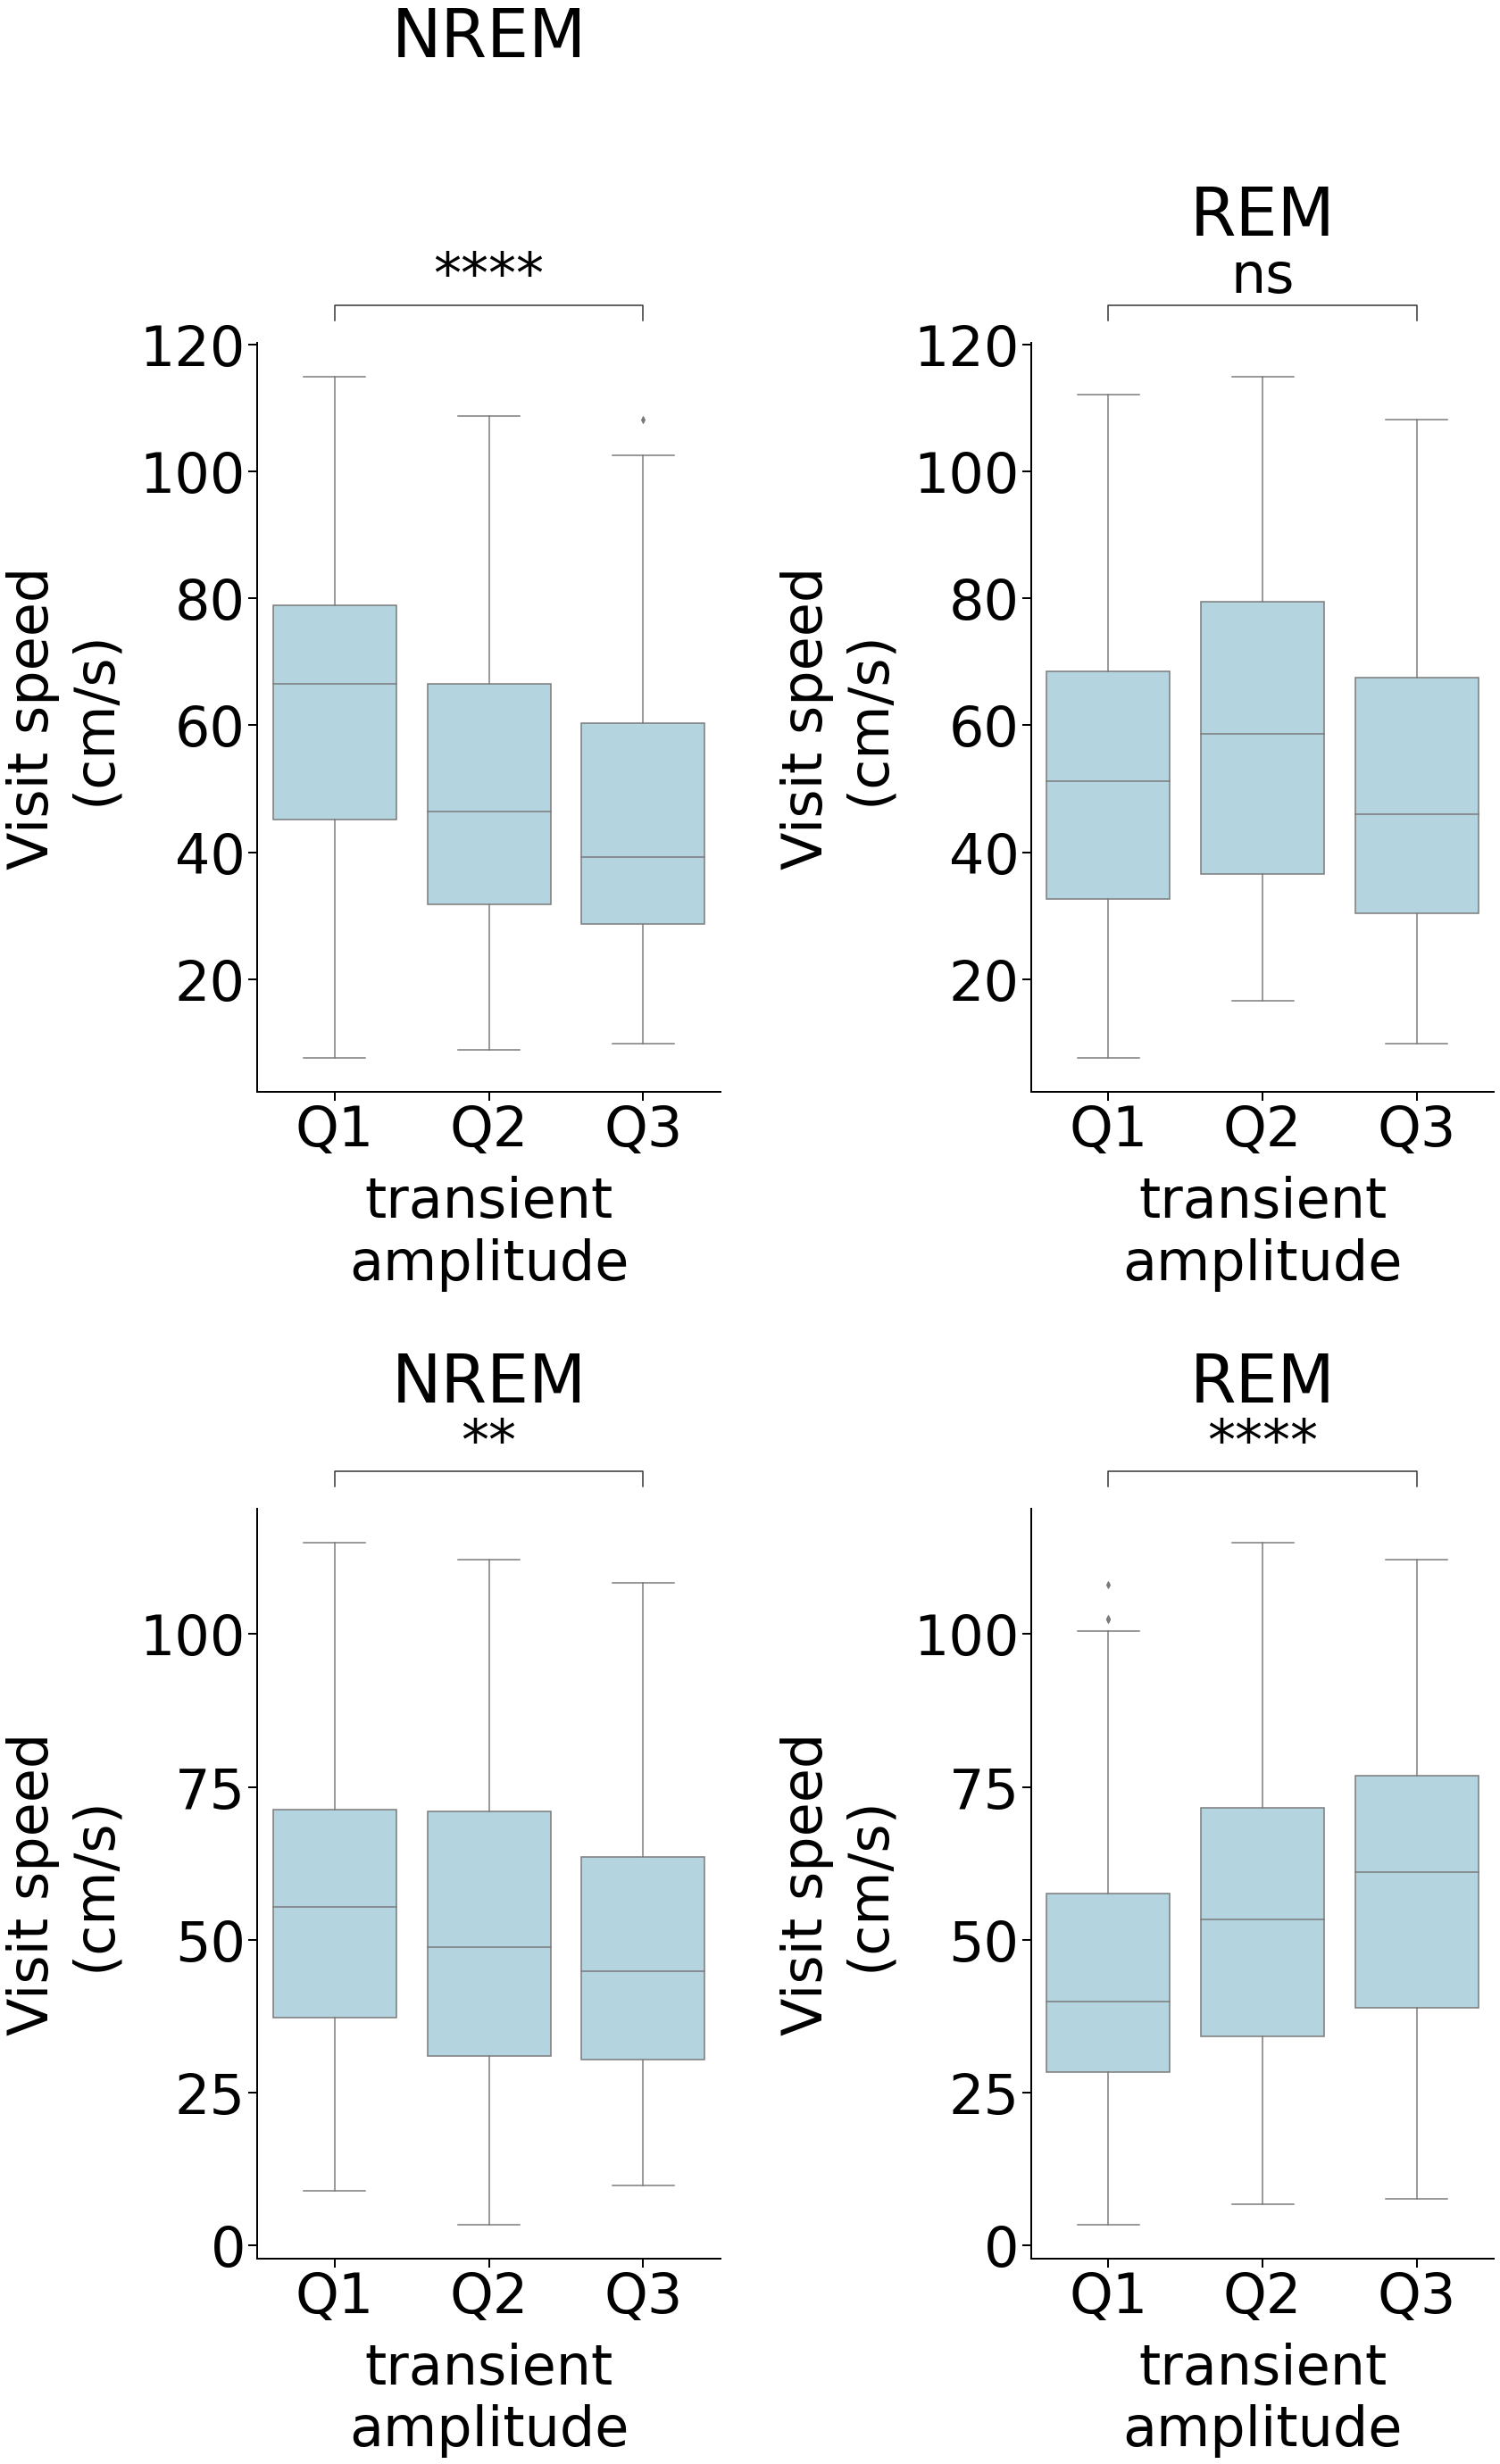

In [38]:
from statannot import add_stat_annotation
from scipy.stats import kruskal, f_oneway
matplotlib.rcParams['font.size'] = 62

fig, ax = plt.subplots(2,2,figsize=(25, 40))

ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0] = sns.boxplot(x="Photom quartiles", y="Mean speed (cm/s)", data=NREM_previous_vs_port_visits, ax=ax[0][0],color='lightblue')
add_stat_annotation(ax[0][0], data=NREM_previous_vs_port_visits, box_pairs= [('Q1', 'Q3')], x="Photom quartiles", y="Mean speed (cm/s)", order=["Q1", "Q2", "Q3"], test='Mann-Whitney', text_format='star', loc='outside', verbose=2, comparisons_correction=None)
ax[0][0].set_xlabel('transient'+'\n'+'amplitude')
ax[0][0].set_ylabel('Visit speed'+'\n'+'(cm/s)')
ax[0][0].set_title('NREM', pad=320)
# [('Q1', 'Q2'), ('Q2', 'Q3'), ('Q1', 'Q3')]

ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1] = sns.boxplot(x="Photom quartiles", y="Mean speed (cm/s)", data=REM_previous_vs_port_visits, ax=ax[0][1], color='lightblue')
add_stat_annotation(ax[0][1], data=REM_previous_vs_port_visits, box_pairs=[('Q1', 'Q3')], x="Photom quartiles", y="Mean speed (cm/s)", order=["Q1", "Q2", "Q3"], test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
ax[0][1].set_xlabel('transient'+'\n'+'amplitude')
ax[0][1].set_ylabel('Visit speed'+'\n'+'(cm/s)')
ax[0][1].set_title('REM', pad=120)

ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0] = sns.boxplot(x="Photom quartiles", y="Mean speed (cm/s)", data=NREM_following_vs_port_visits, ax=ax[1][0], color='lightblue')
add_stat_annotation(ax[1][0], data=NREM_following_vs_port_visits, box_pairs=[('Q1', 'Q3')], x="Photom quartiles", y="Mean speed (cm/s)", order=["Q1", "Q2", "Q3"], test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
ax[1][0].set_xlabel('transient'+'\n'+'amplitude')
ax[1][0].set_ylabel('Visit speed'+'\n'+'(cm/s)')
ax[1][0].set_title('NREM', pad=120)

ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1] = sns.boxplot(x="Photom quartiles", y="Mean speed (cm/s)", data=REM_following_vs_port_visits, ax=ax[1][1], color='lightblue')
add_stat_annotation(ax[1][1], data=REM_following_vs_port_visits, box_pairs=[('Q1', 'Q3')], x="Photom quartiles", y="Mean speed (cm/s)", order=["Q1", "Q2", "Q3"], test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
ax[1][1].set_xlabel('transient'+'\n'+'amplitude')
ax[1][1].set_ylabel('Visit speed'+'\n'+'(cm/s)')
ax[1][1].set_title('REM', pad=120)

plt.subplots_adjust(left=2, right=15)

plt.tight_layout()
plt.show()

findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


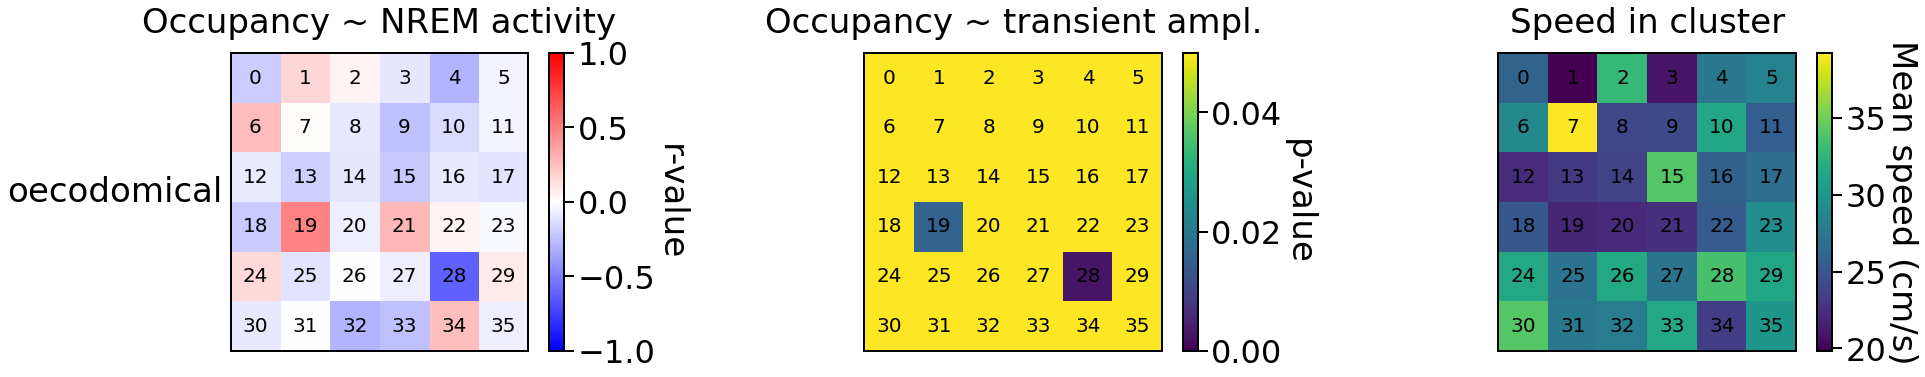

In [19]:
import pickle 
import scipy.stats as stats

matplotlib.rcParams['font.size'] = 32

with open('maze_reconstruction.pickle', 'rb')as handle:
    maze_reconstruction = pickle.load(handle)
    
with open('model_params.pickle', 'rb') as handle:
    params = pickle.load(handle)    

photometry = pd.read_csv("photometry.csv")
genotype = "VGAT"
photom_standardized = True
photom_detrended = True

sleep_phase = "previous"
state = "NREM"

fig, ax = plt.subplots(1, 3, figsize=(10*3, 6))
fig.subplots_adjust(wspace=0.5, hspace=0.75, top=0.93)


def calc_speed(x):
    return (x["X_centre"].diff().pow(2)+x["Y_centre"].diff().pow(2)).pow(1/2)*60*10


photom_df = photometry[(photometry["Genotype"]==genotype)&(photometry["Sleep phase"]==sleep_phase)&(photometry["Standardized"]==photom_standardized)].copy()

if photom_detrended:
    photom_df["Mean transient amplitude (dF/F*s)"]=photom_df.groupby(['Day'])[["Mean transient amplitude (dF/F*s)"]].transform(lambda x: x-x.mean())

r_values = []
p_values = []
speeds = []

for i in range(params["som_dim"]**2):
    df = maze_reconstruction[maze_reconstruction["Genotype"]==genotype].merge(photom_df[photom_df["State"]==state], on=["Animal", "Day"], how='left').dropna()
    photomgrouped_df=df.groupby(["Animal", "Day", "Trial"])
    photomgrouped_cluster_df=df[df["Cluster"]==i].groupby(["Animal", "Day", "Trial"])
    cluster_corrdf=(photomgrouped_cluster_df.count()["Cluster"]/photomgrouped_df.count()["Cluster"]*100).reset_index().rename(columns={"Cluster":"Cluster occupancy (%)"}).dropna()   
    cluster_corrdf_photom=photomgrouped_cluster_df.mean()

    res = stats.linregress(cluster_corrdf_photom["Mean transient amplitude (dF/F*s)"], cluster_corrdf["Cluster occupancy (%)"])
    r_values.append(res.rvalue)
    p_values.append(res.pvalue)
    speeds.append(photomgrouped_cluster_df.apply(calc_speed).mean())


datasets = np.array((r_values, p_values, speeds)).reshape(3,params["som_dim"], params["som_dim"])
datasets_names = ["r-value", "p-value", "Mean speed (cm/s)"]
datasets_titles = ["Occupancy ~ NREM activity", "Occupancy ~ transient ampl.", "Speed in cluster"]
#     datasets_limits = [[-np.max(np.abs(r_values))*1.5, np.max(np.abs(r_values))*1.5], [0,0.05], None]
datasets_limits = [[-1, 1], [0,0.05], None]
datasets_cmap = ["bwr", "viridis", "viridis"]

for i in [0,1,2]:
    ax[i%len(datasets)].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)
    ax[i%len(datasets)].set_title(datasets_titles[i], pad=20, fontsize=34)
    im = ax[i%len(datasets)].imshow(datasets[i,:,:], cmap=datasets_cmap[i])
    cb = plt.colorbar(im, ax=ax[i%len(datasets)], fraction=0.046, pad=0.04)
    
    cb.set_label(datasets_names[i], fontsize=34, rotation=-90, labelpad=32)
    for x in range(params["som_dim"]):
        for y in range(params["som_dim"]):
            text = ax[i%len(datasets)].text(x, y, y*params["som_dim"]+x, ha="center", va="center", color="k", fontsize=20)
    if datasets_limits[i] is not None:
        im.set_clim(datasets_limits[i])
ax[0].text(np.mean(ax[0].get_xlim())-np.diff(ax[0].get_xlim())*1.25, np.mean(ax[0].get_ylim()), params["ex_name"], fontsize=34)     
plt.tight_layout()
plt.show()

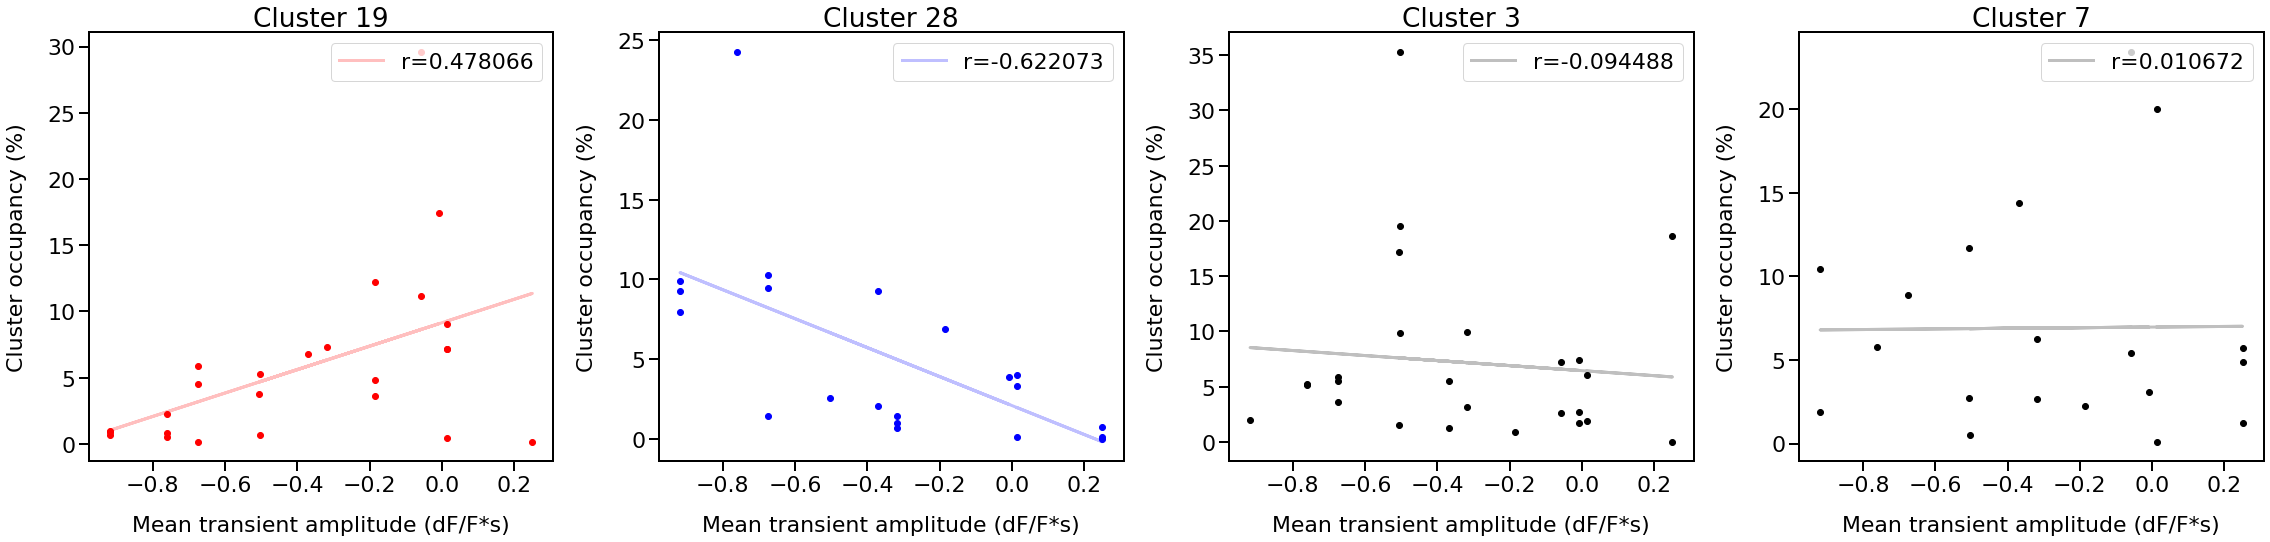

In [32]:

figsize_factor = 8
fig, ax = plt.subplots(1, 4, figsize=(figsize_factor*4, figsize_factor*1))
fig.subplots_adjust(wspace=0.5, hspace=0.5, top=0.93)
matplotlib.rcParams.update({'font.size': 22})
for i, cl in enumerate([19,28,3,7]):
    df = maze_reconstruction[maze_reconstruction["Genotype"]==genotype].merge(photom_df[photom_df["State"]==state], on=["Animal", "Day"], how='left').dropna()
    photomgrouped_df=df.groupby(["Animal", "Day", "Trial"])
    photomgrouped_cluster_df=df[df["Cluster"]==cl].groupby(["Animal", "Day", "Trial"])
    cluster_corrdf=(photomgrouped_cluster_df.count()["Cluster"]/photomgrouped_df.count()["Cluster"]*100).reset_index().rename(columns={"Cluster":"Cluster occupancy (%)"}).dropna()   
    cluster_corrdf_photom=photomgrouped_cluster_df.mean()
    res = stats.linregress(cluster_corrdf_photom["Mean transient amplitude (dF/F*s)"], cluster_corrdf["Cluster occupancy (%)"])
    regline = ax[i].plot(cluster_corrdf_photom["Mean transient amplitude (dF/F*s)"], res.intercept + res.slope*cluster_corrdf_photom["Mean transient amplitude (dF/F*s)"], color=('r' if res.rvalue>0 else 'b') if res.pvalue<0.05 else 'k', linewidth=3, alpha=0.25)
    ax[i].scatter(cluster_corrdf_photom["Mean transient amplitude (dF/F*s)"],cluster_corrdf["Cluster occupancy (%)"], color=('r' if res.rvalue>0 else 'b') if res.pvalue<0.05 else 'k')
    ax[i].set_xlabel("Mean transient amplitude (dF/F*s)")
    ax[i].set_ylabel("Cluster occupancy (%)")
#     ax[i].legend(regline,['r={:f}, p={:f}'.format(res.rvalue,res.pvalue)], loc='upper right')
    ax[i].legend(regline,['r={:f}'.format(res.rvalue)], loc='upper right')

    ax[i].set_title("Cluster " + str(cl))
plt.tight_layout()
plt.show()